In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from funzioni import compute_dataset_weighted
from funzioni import compute_annual_mean_weighted
from funzioni import convert_dataset_celsius
from funzioni import compute_anomaly
from funzioni import create_djf_dataset
from funzioni import compute_mean_time_season
from funzioni import compute_mean_resample_mar
from funzioni import plot_bias_atmos
from funzioni import plot_bias_tos
from funzioni import plot_mean_cluster_atmos
from funzioni import plot_mean_cluster_tos
from funzioni import plot_bias_2_models_atmos
from funzioni import plot_bias_2_models_tos
from funzioni import plot_std_cluster_atmos
from funzioni import plot_zonmean
from funzioni import plot_zonmean_2_cluster
from funzioni import plot_mean_cluster_zonmean
from funzioni import plot_std_cluster_tos
from funzioni import plot_std_cluster_zonmean
from funzioni import bs_sample_mean
from funzioni import bs_compute_array_mean_std_95cl
from funzioni import plot_bs_95cl_mean_std
from funzioni import bs_compute_matrix10
from funzioni import plot_bs_mean_cluster_matrix10
from funzioni import compute_theta
from funzioni import compute_theta_era
from funzioni import compute_derivative
from funzioni import compute_frequency
from funzioni import compute_coriolis_parameter
from funzioni import compute_egr
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import plotly.express as px
import dill
import pickle
import cartopy.crs as ccrs
import random
import math

Caricamento dei file pickle

In [2]:
# Caricamento di models_atmos e models_zonmean
with open('models_atmos.pkl','rb') as file:
    models_atmos = dill.load(file)
    era_na_seas_mean = dill.load(file)
#with open('models_zonmean.pkl','rb') as file:
#    models_zonmean = dill.load(file)
#    era_seas_mean = dill.load(file)
with open('modelli_atmos.pickle', 'rb') as f:
    # Caricamento delle 5 liste contenenti i nomi dei modelli all'interno dei 5 cluster
    list_cluster0 = pickle.load(f)
    list_cluster1 = pickle.load(f)
    list_cluster2 = pickle.load(f)
    list_cluster3 = pickle.load(f)
    list_cluster4 = pickle.load(f)
    
    # Caricamento dei 5 cluster in formato pdf
    atmos_cluster0 = pickle.load(f)
    atmos_cluster1 = pickle.load(f)
    atmos_cluster2 = pickle.load(f)
    atmos_cluster3 = pickle.load(f)
    atmos_cluster4 = pickle.load(f)
    
    # Caricamento dei cluster medi in formato pdf
    atmos_cluster0_mean = pickle.load(f)
    atmos_cluster1_mean = pickle.load(f)
    atmos_cluster2_mean = pickle.load(f)
    atmos_cluster3_mean = pickle.load(f)
    atmos_cluster4_mean = pickle.load(f)

    #Caricamento dei cluster standard deviation in formato pdf
    atmos_cluster0_std = pickle.load(f)
    atmos_cluster1_std = pickle.load(f)
    atmos_cluster2_std = pickle.load(f)
    atmos_cluster3_std = pickle.load(f)
    atmos_cluster4_std = pickle.load(f)
#with open('modelli_zonmean.pickle','rb') as f:
#    #Caricamento dei 5 cluster in formato pdf
#    zonmean_cluster0 = pickle.load(f)
#    zonmean_cluster1 = pickle.load(f)
#    zonmean_cluster2 = pickle.load(f)
#    zonmean_cluster3 = pickle.load(f)
#    zonmean_cluster4 = pickle.load(f)
#    #Caricamento dei cluster medi in formato pdf
#    zonmean_cluster0_mean = pickle.load(f)
#    zonmean_cluster1_mean = pickle.load(f)
#    zonmean_cluster2_mean = pickle.load(f)
#    zonmean_cluster3_mean = pickle.load(f)
#    zonmean_cluster4_mean = pickle.load(f)

Dizionario models_ua, cioè vento zonale su tutti i plev

In [3]:
# creo un dizionario in cui andrò a mettere tutti i modelli dentro
models_ua = {}

In [4]:
#Costruisco il dizionario models_atmos con il nome del modello, il nomde del percorso di tutti i file *.nc di ogni modello e il nome di .nc, cioè il modello remapbil

#Percorso dei file
name_models_ua = '/work/users/guest/sbeltrami/prova/zonal_mean_name_ok_model.txt'
path_models_ua = '/work/users/guest/sbeltrami/prova/path_zonal_mean_model.txt'
path_remap_models_ua = '/work/users/guest/sbeltrami/prova/path_remap_zonal_mean_model.txt'
# Apro i 3 file in modalità di lettura
with open(name_models_ua, 'r') as file:
    # Leggo tutte le righe del file e salvo in una lista
    lines_name_models_ua = file.readlines()
with open(path_models_ua, 'r') as file:
    lines_path_models_ua = file.readlines()
with open(path_remap_models_ua, 'r') as file:
    lines_path_remap_models_ua = file.readlines()

In [5]:
# Itero su tutte le righe dei 3 file e organizzo i dati nel dizionario
for line_name, line_path, line_path_remap in zip(lines_name_models_ua, lines_path_models_ua, lines_path_remap_models_ua): #zip per iterare sulle 3 liste contemporaneamente
    model_name = line_name.strip() #senza spazi bianchi
    #model_name è la chiave principale
    # Inizializzo il dizionario se non esiste ancora
    if model_name not in models_ua:
        models_ua[model_name] = {}
    # Aggiungo name, path, path remap come sottochiavi
    models_ua[model_name]['ua name'] = model_name
    models_ua[model_name]['ua path'] = line_path.strip()
    models_ua[model_name]['ua path remap'] = line_path_remap.strip()
for name in models_ua.keys():
    path_remap = models_ua[name]['ua path remap']
    if os.path.exists(path_remap): #Se il file esiste
        # Apro il dataset
        models_ua[name]['ua dataset'] = xr.open_dataset(path_remap)
        models_ua[name]['ua dataset'] = models_ua[name]['ua dataset'].assign_coords({"plev" : models_ua[name]['ua dataset'].plev.round()}) # Per essere sicuri che i plev siano gli stessi
        models_ua[name]['ua dataset'] = models_ua[name]['ua dataset'].sel(plev=slice(100000.,20000.),time=slice("1982-01", "2014-12")) #taglio al di sopra di 200 hPa e seleziono time
        dataset = models_ua[name]['ua dataset']
        #peso il dataset
        models_ua[name]['ua dataset weighted'] = compute_dataset_weighted(dataset["ua"])
        #Seleziono il box del Nord Atlantico
        # Seleziono la parte delle lon negative
        lon_neg = dataset.sel(lon=slice(235,360), lat=slice(0,90)) #prendo tutto l'emisfero boreale perché dopo calcolo la media zonale nel box -60,0,0,90
        # Seleziono la parte delle lon positive
        lon_pos = dataset.sel(lon=slice(0,30), lat=slice(0,90))
        # Concateno i due subset lungo la dimensione 'lon'
        lon_concat = xr.concat([lon_neg,lon_pos], dim='lon')
        lon_concat = lon_concat.assign_coords(lon=(np.where(lon_concat.lon >= 236, lon_concat.lon - 360, lon_concat.lon)))
        #Box nord Atlantico per longitudine [-126,30]
        models_ua[name]['ua North Atlantic box'] = lon_concat
        na_box = models_ua[name]['ua North Atlantic box']
        #peso il dataset Nord Atlantico
        models_ua[name]['ua North Atlantic dataset weighted'] = compute_dataset_weighted(na_box["ua"])
    else:
        print(f"Errore: Il file {path_remap} non esiste per il modello {name}")

ERA5_ua cioè con dati di vento zonale per ogni plev

In [6]:
#ERA5 box Nord Atlantico
dataset_ERA_ua=xr.open_dataset('/work/users/guest/sbeltrami/prova/ERA5_remapcon_delete.nc')
dataset_ERA_ua = dataset_ERA_ua['var131'].sel(time=slice("1982-01", "2014-12"),plev=slice(100000.,20000.)) #seleziono il periodo 1982 - 2014 e i plev
lon_neg = dataset_ERA_ua.sel(lon=slice(235,360), lat=slice(0,90)) #seleziono il box lonxlat
# Seleziono la parte delle lon positive
lon_pos = dataset_ERA_ua.sel(lon=slice(0,30), lat=slice(0,90))
# Concateno i due subset lungo la dimensione 'lon'
lon_concat = xr.concat([lon_neg,lon_pos], dim='lon')
lon_concat = lon_concat.assign_coords(lon=(np.where(lon_concat.lon >= 236, lon_concat.lon - 360, lon_concat.lon))) #sostituisco i valori da 236 a 358 con numeri negativi, in modo tale che i valori di longitudine siano in ordine crescente
dataset_ERA_ua = lon_concat
#dataset pesato
dataset_ERA_weighted_ua = compute_dataset_weighted(dataset_ERA_ua)

Text(0.5, 1.0, 'ERA5_ua DJF')

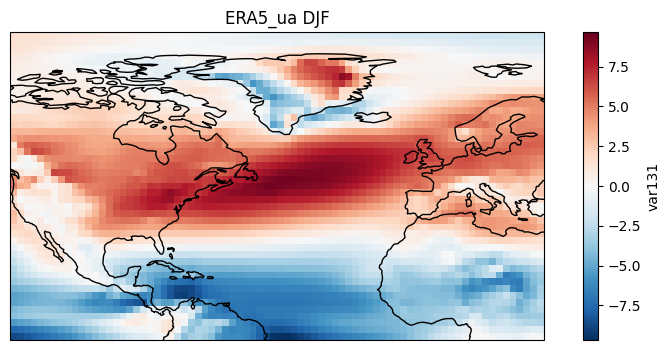

In [7]:
#Creo un dizionario in cui vado a mettere la media temporale per ogni stagione MAM, JJA, SON, DJF
era_ua_seas_mean = {}
#Calcolo la media temporale su tutti e 4 i trimestri MAM = 1, JJA = 2, SON = 3, DJF = 4
for i in range(4):
    era_ua_seas_mean[i+1] = compute_mean_resample_mar(dataset_ERA_ua,"1982","2014",i)
#print(era_ua_seas_mean.keys())
#plot DJF per ERA_ua
fig, ax = plt.subplots(figsize=(10,4), subplot_kw={"projection": ccrs.PlateCarree()})
era_ua_seas_mean[4][2,:,:].plot(ax=ax) #850hPa
ax.coastlines()
ax.set_title('ERA5_ua DJF')

Bias ERA5_ua

Text(0.5, 1.0, 'Plot bias ua DJF per EC-Earth3')

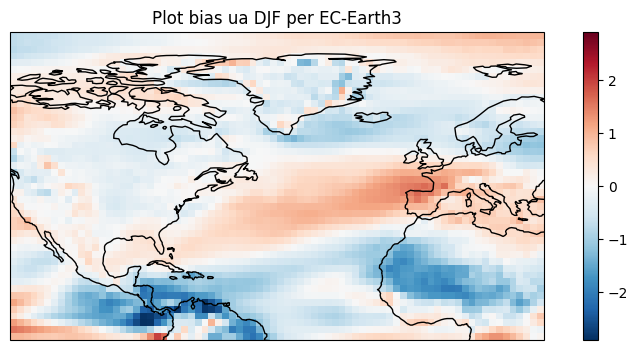

In [8]:
for name in models_ua.keys():
    box = models_ua[name]['ua North Atlantic box']    
    # Media temporale delle stagioni MAM, JJA, SON
    for i in range(4): # Ciclo su tutte le stagioni
        # Calcolo la media temporale per ogni stagione dei modelli
        if (i+1) == 4 : # DJF
            models_ua[name]['ua seasonal mean DJF'] = compute_mean_resample_mar(box["ua"],"1982","2014",i)
            model_seas_mean = models_ua[name]['ua seasonal mean DJF']
            models_ua[name]['ua bias DJF'] = model_seas_mean - era_ua_seas_mean[i+1]

#Plot bias ua per un modello
#plot DJF
name = 'EC-Earth3' #nome modello che plotto
fig, ax = plt.subplots(figsize=(10,4), subplot_kw={"projection": ccrs.PlateCarree()})
models_ua[name]['ua bias DJF'][2,:,:].plot(ax=ax) #plev=850hPa
ax.coastlines()
ax.set_title(f'Plot bias ua DJF per {name}')

Dizionario models_ta, cioè temperatura su tutti i plev

In [9]:
# creo un dizionario in cui andrò a mettere tutti i modelli dentro
models_ta = {}

In [10]:
#Percorso dei file
name_models_ta = '/work/users/guest/sbeltrami/prova/ta_name_ok_model.txt'
path_models_ta = '/work/users/guest/sbeltrami/prova/path_temperature_model.txt'
path_remap_models_ta = '/work/users/guest/sbeltrami/prova/path_remap_ta_model.txt'
# Apro i 3 file in modalità di lettura
with open(name_models_ta, 'r') as file: #nome file
    # Leggo tutte le righe del file e salvo in una lista
    lines_name_models_ta = file.readlines()
with open(path_models_ta, 'r') as file: #percorso dei file .nc
    lines_path_models_ta = file.readlines()
with open(path_remap_models_ta, 'r') as file: #percorso dei file remap
    lines_path_remap_models_ta = file.readlines()
for line_name, line_path, line_path_remap in zip(lines_name_models_ta, lines_path_models_ta, lines_path_remap_models_ta): #zip per iterare sulle 3 liste contemporaneamente
    model_name = line_name.strip() #senza spazi bianchi
    #model_name è la chiave principale
    # Inizializzo il dizionario se non esiste ancora
    if model_name not in models_ta:
        models_ta[model_name] = {}
    # Aggiungo name, path, path remap come sottochiavi
    models_ta[model_name]['ta name'] = model_name
    models_ta[model_name]['ta path'] = line_path.strip()
    models_ta[model_name]['ta path remap'] = line_path_remap.strip()
for name in models_ta.keys():
    path_remap = models_ta[name]['ta path remap']
    if os.path.exists(path_remap): #Se il file esiste
        # Apro il dataset
        models_ta[name]['ta dataset'] = xr.open_dataset(path_remap)
        models_ta[name]['ta dataset'] = models_ta[name]['ta dataset'].assign_coords({"plev" : models_ta[name]['ta dataset'].plev.round()}) # Per essere sicuri che i plev siano gli stessi
        models_ta[name]['ta dataset'] = models_ta[name]['ta dataset'].sel(plev=slice(100000.,20000.),time=slice("1982-01", "2014-12")) #taglio al di sopra di 200 hPa e seleziono time
        dataset = models_ta[name]['ta dataset']
        #peso il dataset
        models_ta[name]['ta dataset weighted'] = compute_dataset_weighted(dataset["ta"])
        #Seleziono il box del Nord Atlantico
        # Seleziono la parte delle lon negative
        lon_neg = dataset.sel(lon=slice(235,360), lat=slice(0,90))
        # Seleziono la parte delle lon positive
        lon_pos = dataset.sel(lon=slice(0,30), lat=slice(0,90))
        # Concateno i due subset lungo la dimensione 'lon'
        lon_concat = xr.concat([lon_neg,lon_pos], dim='lon')
        lon_concat = lon_concat.assign_coords(lon=(np.where(lon_concat.lon >= 236, lon_concat.lon - 360, lon_concat.lon)))
        #Box nord Atlantico per longitudine [-126,30]
        models_ta[name]['ta North Atlantic box'] = lon_concat
        na_box = models_ta[name]['ta North Atlantic box']
        #peso il dataset Nord Atlantico
        models_ta[name]['ta North Atlantic dataset weighted'] = compute_dataset_weighted(na_box["ta"])
    else:
        print(f"Errore: Il file {path_remap} non esiste per il modello {name}")

ERA5_ta cioè con dati di temperatura per ogni plev

In [11]:
#ERA5 box Nord Atlantico
dataset_ERA_ta=xr.open_dataset('/work/users/guest/sbeltrami/prova/ERA5_ta_remap.nc')
dataset_ERA_ta = dataset_ERA_ta['t'].sel(time=slice("1982-01", "2014-12"),plev=slice(100000.,20000.)) #seleziono il periodo 1982 - 2014 e i plev
lon_neg = dataset_ERA_ta.sel(lon=slice(235,360), lat=slice(0,90)) #seleziono il box lonxlat
# Seleziono la parte delle lon positive
lon_pos = dataset_ERA_ta.sel(lon=slice(0,30), lat=slice(0,90))
# Concateno i due subset lungo la dimensione 'lon'
lon_concat = xr.concat([lon_neg,lon_pos], dim='lon')
lon_concat = lon_concat.assign_coords(lon=(np.where(lon_concat.lon >= 236, lon_concat.lon - 360, lon_concat.lon))) #sostituisco i valori da 236 a 358 con numeri negativi, in modo tale che i valori di longitudine siano in ordine crescente
dataset_ERA_ta = lon_concat
#dataset pesato
dataset_ERA_weighted_ta = compute_dataset_weighted(dataset_ERA_ta)

Text(0.5, 1.0, 'ERA5_ta DJF')

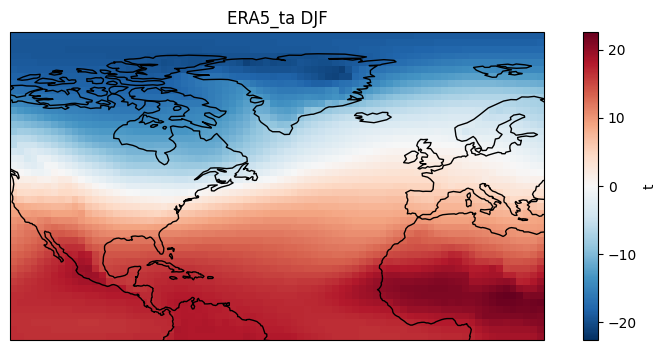

In [12]:
#Creo un dizionario in cui vado a mettere la media temporale per ogni stagione MAM, JJA, SON, DJF
era_ta_seas_mean = {}
#Calcolo la media temporale su tutti e 4 i trimestri MAM = 1, JJA = 2, SON = 3, DJF = 4
for i in range(4):
    era_ta_seas_mean[i+1] = compute_mean_resample_mar(dataset_ERA_ta,"1982","2014",i) - 273.15
#print(era_ua_seas_mean.keys())
#plot DJF ERA5_ta
fig, ax = plt.subplots(figsize=(10,4), subplot_kw={"projection": ccrs.PlateCarree()})
era_ta_seas_mean[4][2,:,:].plot(ax=ax) #plev=850hPa
ax.coastlines()
ax.set_title('ERA5_ta DJF')

Bias ERA5_ta

In [13]:
for name in models_ta.keys():
    box = models_ta[name]['ta North Atlantic box']    
    # Media temporale delle stagioni MAM, JJA, SON
    for i in range(4): # Ciclo su tutte le stagioni
        # Calcolo la media temporale per ogni stagione dei modelli
        if (i+1) == 4 : # DJF
            models_ta[name]['ta seasonal mean DJF'] = compute_mean_resample_mar(box["ta"],"1982","2014",i) - 273.15
            model_seas_mean = models_ta[name]['ta seasonal mean DJF']
            models_ta[name]['ta bias DJF'] = model_seas_mean - era_ta_seas_mean[i+1]

Text(0.5, 1.0, 'Plot bias ta DJF per EC-Earth3')

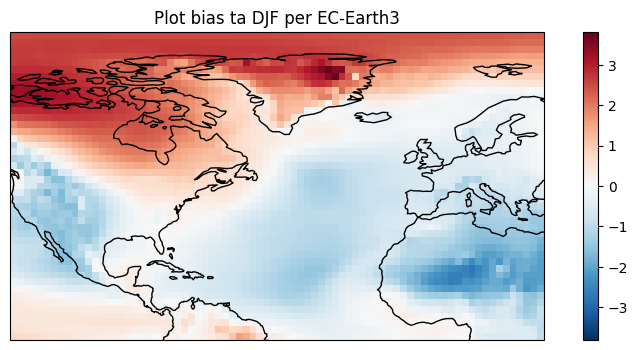

In [14]:
#Plot di bias DJF per un modello
#plot DJF
name = 'EC-Earth3' #nome modello che plotto
fig, ax = plt.subplots(figsize=(10,4), subplot_kw={"projection": ccrs.PlateCarree()})
models_ta[name]['ta bias DJF'][2,:,:].plot(ax=ax) #plev=850hPa
ax.coastlines()
ax.set_title(f'Plot bias ta DJF per {name}')

1) Creare funzione per calcolo theta: theta = ta * (p0 / p) ^ (R / cp)
2) Creare funzione per il calcolo della derivata verticale (sia per u(z) sia per theta)
3) Creare funzione per il calcolo di N: N ^ 2 = (g / theta) * (d(theta) / dz)
4) Creare funzione per il calcolo di f: f = 2 * omega * sin(phi)
5) Calcolo di EGR: sigma = 0.3068 * f * |(du / dz)| * N ^ (-1)

In [15]:
for name in models_ta.keys():
    #calcolo theta
    models_ta[name]['potential temperature (theta) DJF'] = compute_theta(models_ta,name) #bias di temperatura potenziale per ogni modello, mesi DJF
    #dimensioni di plev, lat, lon
    theta_plev = len(models_ta['TaiESM1']['potential temperature (theta) DJF'][:,0,0])
    theta_lat = len(models_ta['TaiESM1']['potential temperature (theta) DJF'][0,:,0])
    theta_lon = len(models_ta['TaiESM1']['potential temperature (theta) DJF'][0,0,:])
    #calcolo la derivata di theta e ua
    models_ta[name]['theta derivative DJF'] = compute_derivative(theta_plev,theta_lat,theta_lon,models_ta[name]['potential temperature (theta) DJF'],models_ua[name]['ua seasonal mean DJF'].plev) #derivata di theta rispetto alla pressione per il periodo DJF
    models_ua[name]['ua derivative DJF'] = compute_derivative(theta_plev,theta_lat,theta_lon,models_ua[name]['ua seasonal mean DJF'],models_ua[name]['ua seasonal mean DJF'].plev) #derivata di ua rispetto alla pressione per il periodo DJF
    #calcolo N
    models_ta[name]['Brunt-Väisälä frequency (N)'] = compute_frequency(theta_plev,theta_lat,theta_lon,models_ta[name]['potential temperature (theta) DJF'],models_ta[name]['theta derivative DJF'])
    #calcolo f
    models_ta[name]['Coriolis parameter f']= compute_coriolis_parameter(theta_lat,models_ua[name]['ua seasonal mean DJF'])
    #calcolo sigma
    models_ta[name]['Eady Growth Rate'] = compute_egr(theta_plev,theta_lat,theta_lon,models_ta[name]['Coriolis parameter f'],models_ua[name]['ua derivative DJF'],models_ta[name]['Brunt-Väisälä frequency (N)'])  

In [16]:
models_ta['ACCESS-CM2']['Eady Growth Rate']

array([[[2.90497181e-09, 1.39927941e-09, 4.40274934e-10, ...,
                    nan,            nan,            nan],
        [2.12847145e-08, 1.97268617e-08, 1.74136455e-08, ...,
                    nan,            nan,            nan],
        [4.93466963e-08, 4.90157316e-08, 4.79928947e-08, ...,
                    nan,            nan,            nan],
        ...,
        [1.36841054e-07, 1.39090954e-07, 1.36865896e-07, ...,
         1.05385799e-06, 1.04208213e-06, 1.02333863e-06],
        [2.31606583e-07, 2.35432557e-07, 2.40322702e-07, ...,
         7.12191832e-07, 7.10286304e-07, 7.06184351e-07],
        [3.53552354e-07, 3.57866150e-07, 3.63472686e-07, ...,
         5.16879878e-07, 5.19602831e-07, 5.21593945e-07]],

       [[9.65269613e-09, 7.42586221e-09, 5.03766754e-09, ...,
         4.38438442e-08, 4.34515560e-08,            nan],
        [1.67952697e-08, 2.33423581e-08, 3.00155520e-08, ...,
         1.50944404e-07, 1.38288164e-07, 1.38965725e-07],
        [5.74935113e-08, 

Calcolo di Eady growth rate per ERA5

In [17]:
dict_egr_era = {}

In [18]:
#calcolo theta
#era_theta = compute_theta_era(era_ta_seas_mean) #bias di temperatura potenziale per ogni modello, mesi DJF
dict_egr_era['theta'] = compute_theta_era(era_ta_seas_mean) #bias di temperatura potenziale per ogni modello, mesi DJF
#dimensioni di plev, lat, lon
theta_plev = len(era_ta_seas_mean[4][:,0,0])
theta_lat = len(era_ta_seas_mean[4][0,:,0])
theta_lon = len(era_ta_seas_mean[4][0,0,:])
#calcolo la derivata di theta e ua
dict_egr_era['derivative theta'] = compute_derivative(theta_plev,theta_lat,theta_lon,dict_egr_era['theta'],era_ua_seas_mean[4].plev) #derivata di theta rispetto alla pressione per il periodo DJF
dict_egr_era['derivative ua'] = compute_derivative(theta_plev,theta_lat,theta_lon,era_ua_seas_mean[4],era_ua_seas_mean[4].plev) #derivata di ua rispetto alla pressione per il periodo DJF
#calcolo N
dict_egr_era['Brunt-Väisälä frequency (N)'] = compute_frequency(theta_plev,theta_lat,theta_lon,dict_egr_era['theta'],dict_egr_era['derivative theta'])
#calcolo f
dict_egr_era['Coriolis parameter f'] = compute_coriolis_parameter(theta_lat,era_ta_seas_mean[4])
#calcolo sigma
dict_egr_era['Eady Growth Rate'] = compute_egr(theta_plev,theta_lat,theta_lon,dict_egr_era['Coriolis parameter f'],dict_egr_era['derivative ua'],dict_egr_era['Brunt-Väisälä frequency (N)'])  

Salvataggio in file pickle

In [19]:
# Salvataggio di models_zonmean
with open('models_ua.pkl', 'wb') as file:
    dill.dump(models_ua, file)
    dill.dump(era_ua_seas_mean,file)
with open('models_ta.pkl', 'wb') as file:
    dill.dump(models_ta, file)
    dill.dump(era_ta_seas_mean,file)
    dill.dump(dict_egr_era,file) #dizionario di ERA5_ta per il calcolo di egr